<a href="https://colab.research.google.com/github/ocean010315/Extract-Laundry-Label-Symbol/blob/OCR-ImageToText/easyOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install easyocr
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 22.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get update -qq
!apt-get install -y fonts-nanum
!fc-cache -fv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (16.5 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 122545 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

In [ ]:
import matplotlib.font_manager as fm

sys_font=fm.findSystemFonts()

nanum_font = [f for f in sys_font if 'Nanum' in f]
nanum_font

['/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf']

In [ ]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import cv2
import requests
import numpy as np
from PIL import ImageFont, ImageDraw, Image

In [ ]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []

  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])

  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)

  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]

  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

  findCnt = None

  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break


  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))


  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)

  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)

  return transform_image


def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
  # Colab이 아닌 Local에서 수행 시에는 gulim.ttc 를 사용하면 됩니다.
  # font = ImageFont.truetype("fonts/gulim.ttc", font_size)
  font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', font_size)
  img = Image.fromarray(cv_img)
   
  draw = ImageDraw.Draw(img)
  draw.text((x, y), text, font=font, fill=color)

  cv_img = np.array(img)
  
  return cv_img

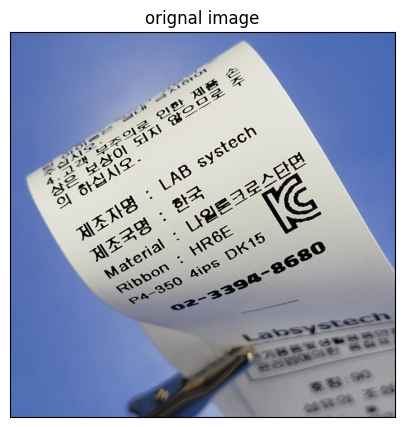

In [ ]:
url = 'https://cdn.imweb.me/thumbnail/20220620/20e6c9138c631.jpg'

image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
plt_imshow("orignal image", org_image)

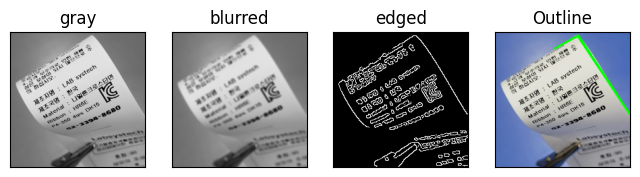

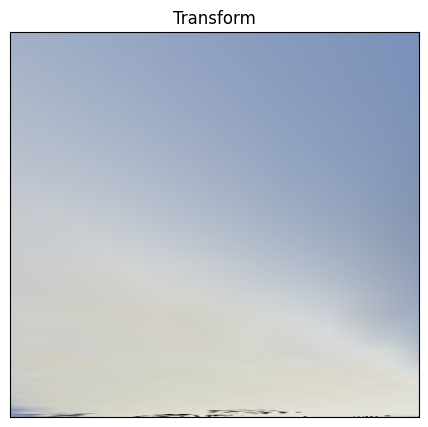

In [ ]:
business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [ ]:
langs = ['ko', 'en']

print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=False)
results = reader.readtext(business_card_image)

[INFO] OCR'ing input image...


In [ ]:
results

[]

In [ ]:
simple_results = reader.readtext(business_card_image, detail = 0)
simple_results

['품질경영 및 공산품안전', '관리법에 의한 품질표시']

In [ ]:
# loop over the results
for (bbox, text, prob) in results:
  print("[INFO] {:.4f}: {}".format(prob, text))
  
  (tl, tr, br, bl) = bbox
  tl = (int(tl[0]), int(tl[1]))
  tr = (int(tr[0]), int(tr[1]))
  br = (int(br[0]), int(br[1]))
  bl = (int(bl[0]), int(bl[1]))

	# 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
  cv2.rectangle(business_card_image, tl, br, (0, 255, 0), 2)
  business_card_image = putText(business_card_image, text, tl[0], tl[1] - 60, (0, 255, 0), 50)
	# cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

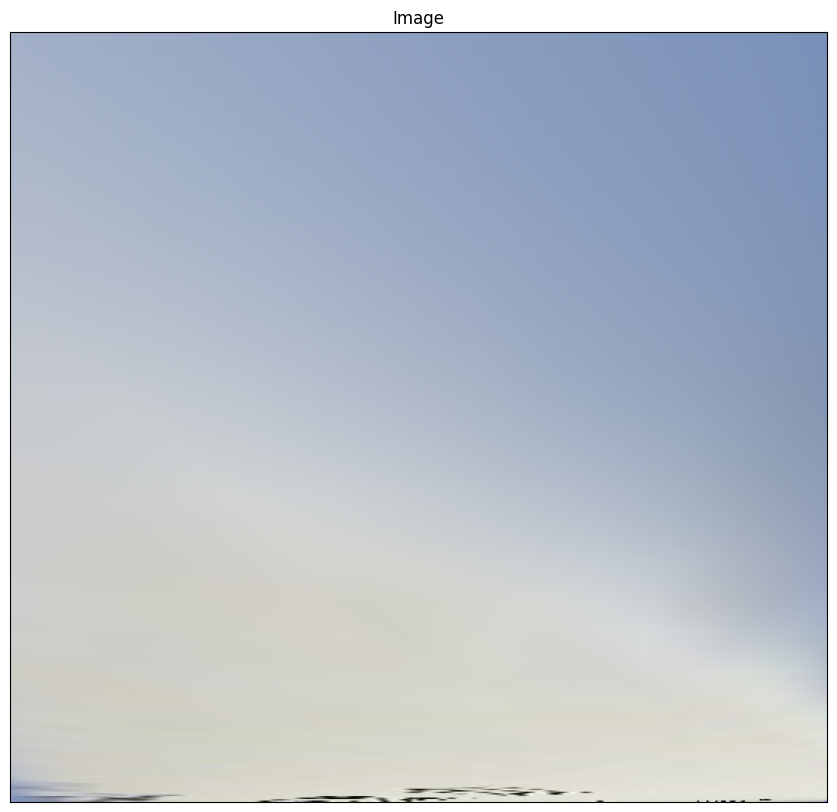

In [ ]:
# show the output image
plt_imshow("Image", business_card_image, figsize=(16,10))